In [1]:
# Lending Club Model v2

#**Purpose:** A fresh modeling pipeline using the full raw feature set  
#**Date:** 2025-06-08


In [2]:
# Standard imports
import pandas as pd
import numpy as np

# Data splitting & imbalance
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Tree-based model (we’ll start here)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, recall_score, roc_curve

# Neural-net libraries (if you want to compare later)
from tensorflow import keras
from tensorflow.keras import layers, regularizers


In [3]:
DATA_PATH = '../data/loan_data_ready_raw.csv'
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape =", df.shape)
df.head()



Loaded: ../data/loan_data_ready_raw.csv shape = (9578, 20)


,credit.policy,int.rate,installment,log.annual.inc,dti,fico,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,cr_line_years,pub_rec_flag,inquiry_rate,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,-0.139318,2.463099,0.680388,0.998505,0.688825,0.182704,-0.716989,-0.299730,-0.237003,0,0.432230,0,-0.345806,False,True,False,False,False,False
1,1,-0.578868,-0.438854,0.244031,0.244540,-0.101303,1.030602,-0.716989,-0.299730,-0.237003,0,-0.721230,0,-0.345806,True,False,False,False,False,False
2,1,0.486484,0.230708,-0.908659,-0.141885,-0.759742,-0.730683,-0.262470,-0.299730,-0.237003,0,0.059770,0,-0.214042,False,True,False,False,False,False
3,1,-0.813544,-0.757022,0.680388,-0.654697,0.030385,0.909966,-0.262470,-0.299730,-0.237003,0,-0.745277,0,-0.115947,False,True,False,False,False,False
4,1,0.743509,-1.043992,0.597961,0.343326,-1.154806,-0.251586,-0.716989,1.531147,-0.237003,0,-0.198161,0,-0.345806,True,False,False,False,False,False


In [4]:
# Cell 4: Create train / validation / test splits

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

TARGET = 'not.fully.paid'
X = df.drop(columns=[TARGET])
y = df[TARGET]

# 1) First split: train vs. test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

# 2) Second split: sub-train vs. validation (from the training portion)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train,
    stratify=y_train,
    test_size=0.2,       # 20% of the TRAINING set → 16% overall
    random_state=42
)

# 3) Compute class weights on the original train set
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
class_weights = {0: weights[0], 1: weights[1]}

print("Train default rate:", y_train.mean())
print("Class weights:", class_weights)


Train default rate: 0.16001044113808405
Class weights: {0: 0.5952454940957116, 1: 3.124796084828711}


In [11]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(
    class_weight='balanced',
    max_iter=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
hgb.fit(X_train, y_train)


y_prob = gbt.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_prob)
sens = recall_score(y_test, y_prob >= 0.40)

print(f"GBT baseline AUC = {auc:.4f}")
print(f"GBT Sensitivity @0.40 = {sens:.4f}")



GBT baseline AUC = 0.6704
GBT Sensitivity @0.40 = 0.0651


In [12]:
# Find optimal threshold via Youden's J

from sklearn.metrics import roc_curve

# y_prob is already defined in Cell 5 as gbt.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
specificity = 1 - fpr
j_scores   = tpr + specificity - 1

best_idx       = j_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Optimal threshold (Youden’s J): {best_threshold:.2f}")
print(f"  Sensitivity: {tpr[best_idx]:.2f}")
print(f"  Specificity: {specificity[best_idx]:.2f}")

# Now you can use best_threshold in your sweep or final predictions:
#    y_pred = (y_prob >= best_threshold).astype(int)


Optimal threshold (Youden’s J): 0.16
  Sensitivity: 0.60
  Specificity: 0.65


In [7]:
from sklearn.metrics import confusion_matrix

y_prob = gbt.predict_proba(X_test)[:,1]

def thr_metrics(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'threshold': thr,
        'sensitivity': tp/(tp+fn),
        'specificity': tn/(tn+fp),
        'accuracy':   (tp+tn)/(tp+tn+fp+fn)
    }

# Sweep
threshs = np.linspace(0,1,21)
metrics = [thr_metrics(y_test, y_prob, t) for t in threshs]
import pandas as pd
df_thresh = pd.DataFrame(metrics)
print(df_thresh)


    threshold  sensitivity  specificity  accuracy
0        0.00     1.000000     0.000000  0.160230
1        0.05     0.983713     0.100684  0.242171
2        0.10     0.912052     0.262275  0.366388
3        0.15     0.612378     0.615911  0.615344
4        0.20     0.407166     0.802983  0.739562
5        0.25     0.273616     0.899316  0.799061
6        0.30     0.172638     0.940336  0.817328
7        0.35     0.120521     0.967682  0.831942
8        0.40     0.065147     0.981355  0.834551
9        0.45     0.055375     0.987570  0.838205
10       0.50     0.029316     0.994406  0.839770
11       0.55     0.016287     0.996271  0.839248
12       0.60     0.006515     0.997514  0.838727
13       0.65     0.003257     0.998135  0.838727
14       0.70     0.003257     0.998757  0.839248
15       0.75     0.003257     0.999378  0.839770
16       0.80     0.000000     1.000000  0.839770
17       0.85     0.000000     1.000000  0.839770
18       0.90     0.000000     1.000000  0.839770



=== Trial params: {'first_layer': 64, 'second_layer': 32, 'dropout1': 0.3, 'dropout2': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001} ===
Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5494 - auc: 0.5213 - loss: 0.7867 - sensitivity: 0.4588 - val_accuracy: 0.5727 - val_auc: 0.6324 - val_loss: 0.6790 - val_sensitivity: 0.5714 - learning_rate: 0.0010
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6043 - auc: 0.6453 - loss: 0.6870 - sensitivity: 0.5895 - val_accuracy: 0.6451 - val_auc: 0.6452 - val_loss: 0.6545 - val_sensitivity: 0.5469 - learning_rate: 0.0010
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6087 - auc: 0.6097 - loss: 0.7177 - sensitivity: 0.5393 - val_accuracy: 0.6027 - val_auc: 0.6484 - val_loss: 0.6730 - val_sensitivity: 0.5918 - learning_rate: 0.0010
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5995 - auc: 0.6448 - loss: 0.6683 - sensitivity: 0.5722 - val_accuracy: 0.6425 - val_auc: 0.654

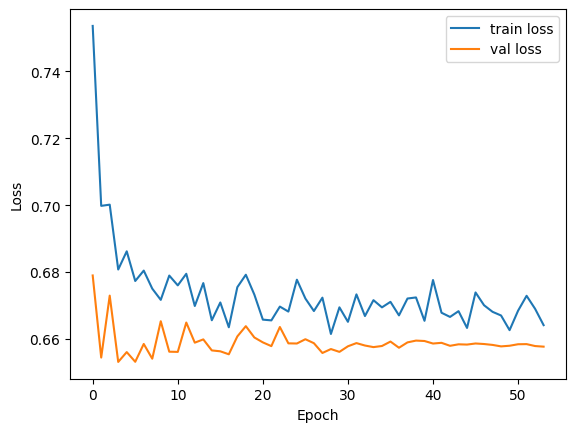


Validation specificity @ 0.16: 0.01


In [14]:
# Cell: Define and train extended neural network trial with callbacks

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) Model factory with key metrics
def make_model(first_layer,
               second_layer,
               dropout1,
               dropout2,
               l2_reg,
               learning_rate):
    model = keras.Sequential([
        layers.Input(shape=(X_train_sub.shape[1],)),
        layers.Dense(first_layer,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout1),
        layers.Dense(second_layer,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.Recall(name='sensitivity'),
            keras.metrics.AUC(name='auc'),
            'accuracy'
        ]
    )
    return model

# 2) Callbacks for up to 1000 epochs
es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# 3) Single extended training trial
params = {
    'first_layer': 64,
    'second_layer': 32,
    'dropout1': 0.3,
    'dropout2': 0.2,
    'l2_reg': 1e-4,
    'learning_rate': 1e-3
}
print(f"\n=== Trial params: {params} ===")
model = make_model(**params)

history = model.fit(
    X_train_sub, y_train_sub,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=256,
    class_weight=class_weights,
    callbacks=[es, rlrop],
    verbose=1
)

# 4) Plot loss curves
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5) Compute specificity at threshold 0.16
best_threshold = 0.16
y_val_probs = model.predict(X_val, verbose=0).ravel()
y_val_pred  = (y_val_probs >= best_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
specificity = tn / (tn + fp)
print(f"\nValidation specificity @ {best_threshold}: {specificity:.2f}")




In [15]:
# Cell: Compute this model’s optimal threshold via Youden’s J

from sklearn.metrics import roc_curve, confusion_matrix

# 1) Get validation probabilities
y_val_probs = model.predict(X_val, verbose=0).ravel()

# 2) Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
specificity = 1 - fpr
j_scores   = tpr + specificity - 1

# 3) Select the best threshold
best_idx       = j_scores.argmax()
best_threshold = thresholds[best_idx]
print(f"Optimal threshold for this net: {best_threshold:.2f}")
print(f"  Sensitivity: {tpr[best_idx]:.2f}")
print(f"  Specificity: {specificity[best_idx]:.2f}")

# 4) Confusion matrix at that threshold
y_val_pred = (y_val_probs >= best_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
print(f"Confusion matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")


Optimal threshold for this net: 0.53
  Sensitivity: 0.53
  Specificity: 0.71
Confusion matrix: TN=917, FP=371, FN=115, TP=130
